In [1]:
import os,sys
import json
import geoplot
import pyproj
import json
import requests
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches

import numpy as np
import pandas as pd
import geopandas as gpd

from functools import partial
from shapely.ops import transform
from io import StringIO
from shapely.geometry import Point, Polygon, mapping

%matplotlib inline

In [2]:
!cd

C:\Users\Timo\AnacondaProjects\work\wmo-notebooks


In [3]:
datadir = r"./data/"

if not os.path.isdir(datadir):
    print("warning..data not in place.. install large file system git")
    sys.exit(1)


# Load WMO Member information 
The boundaries, regional info and membership info are all included in the shapefile 

In [4]:
world_shapefile = os.path.join( datadir , "WMO/WMO-shapefile-BCT-ex.shp" )

gdf_world = gpd.read_file( world_shapefile )
gdf_world.crs = "epsg:4326"

print(gdf_world.shape)
gdf_world.head(1)

(214, 12)


,STATUS,TERR_NAME,POL_C_CODE,ABBREV,SHORT_NAME,ISO_2_CODE,LABELRANK,ISO_CODE_N,wmo_region,regional_i,wmo_member,geometry
0,WMO Member,Anguilla,AIA,B.C.T,Anguilla,AI,2.0,660.0,IV,IV,None,"POLYGON ((-63.15375 18.16528, -63.16778 18.164..."


## load geodata and world bank data for surface area 
We combine information from the World Bank (surface eare), marineregions.org (EEZs and inland lakes)
We also process data, e.g to add Greenland to Denmark and complete missing data (e.g Sudan)

In [5]:
# EEZs 
gdf_eez = gpd.read_file("zip://"+os.path.join( datadir , 'EEZ/eez_v10.zip')  ).set_index("ISO_Ter1")
gdf_eez.crs = "epsg:4326"

gdf_eez=gdf_eez[gdf_eez["Pol_type"]=='200NM'] # remove disputed

df_eez = gdf_eez.reset_index().groupby('ISO_Ter1')["Area_km2"].sum().to_frame()
df_eez.columns = ['eez_area_km2']
df_eez.loc['DNK','eez_area_km2'] += df_eez.loc['GRL','eez_area_km2'] #add Greenland to Denmark

gdf_world=gdf_world.join(df_eez,on="POL_C_CODE") # add EEZ to our dataframe

# inland waters
gdf_inland_water = gpd.read_file("zip://"+os.path.join( datadir , 'EEZ/eez_internal_waters_v2.zip') ).set_index("ISO_Ter1")

df_int_water = gdf_inland_water.groupby('ISO_Ter1')["Area_km2"].sum().to_frame()
df_int_water.columns = ['int_water_km2']
df_int_water.loc['DNK','int_water_km2'] += df_int_water.loc['GRL','int_water_km2'] # add Greenland to Denmark

gdf_world=gdf_world.join(df_int_water,on="POL_C_CODE") # add inland water to our dataframe

# read surface area from World Bank data
df_surface_area = pd.read_csv( os.path.join( datadir ,  'WB\API_AG.LND.TOTL.K2_DS2_en_csv_v2_10578310.csv'),skiprows=4).set_index("Country Code")
df_surface_area.loc['DNK','2017'] += df_surface_area.loc['GRL','2017'] # combine Denmark and Greenland
df_surface_area = df_surface_area[["Country Name","2017"]].rename(columns={"2017":"surface_area_km2_wb"})

# add computed and World Bank land area size and create totals
gdf_world_area=gdf_world.join((gdf_world.to_crs("+proj=eqearth").area/10**6).to_frame().rename(columns={0:"surface_area_km2_comp"}))
gdf_world_area=gdf_world_area.join(df_surface_area,on="POL_C_CODE")

# no WB data for South Sudan and Sudan.. use GIS calculated values 
sdn_idx = gdf_world_area.POL_C_CODE.isin(["SDN","SSD"])
gdf_world_area.loc[sdn_idx,"surface_area_km2_wb"] = gdf_world_area.loc[sdn_idx,"surface_area_km2_comp"]

gdf_world_area["surface_area_total_km2"] = gdf_world_area[["surface_area_km2_wb","eez_area_km2","int_water_km2"]].sum(axis=1) 
#gdf_world_area=gdf_world_area[["STATUS","TERR_NAME","POL_C_CODE","geometry","Numeric","surface_area_km2_comp","surface_area_km2_wb","surface_area_total_km2","eez_area_km2","int_water_km2"]]
gdf_world_area=gdf_world_area.set_index("POL_C_CODE")

# add numeric iso code to EEZ GDF
gdf_eez=gdf_eez.join(gdf_world_area[["ISO_CODE_N",]],how="inner")

gdf_world_area.head(2)

# TODO.. do we need to integrate futher areas, 
# US: Marshall Islands, Puerto Rico
# Netherlands: Sint Maarten
# Curacao 


,STATUS,TERR_NAME,ABBREV,SHORT_NAME,ISO_2_CODE,LABELRANK,ISO_CODE_N,wmo_region,regional_i,wmo_member,geometry,eez_area_km2,int_water_km2,surface_area_km2_comp,Country Name,surface_area_km2_wb,surface_area_total_km2
POL_C_CODE,,,,,,,,,,,,,,,,,
AIA,WMO Member,Anguilla,B.C.T,Anguilla,AI,2.0,660.0,IV,IV,None,"POLYGON ((-63.15375 18.16528, -63.16778 18.164...",90426.0,NaN,91.276776,NaN,NaN,90426.0
MSR,WMO Member,Montserrat,B.C.T,Montserrat,MS,2.0,500.0,IV,IV,None,"POLYGON ((-62.16556 16.67166, -62.17139 16.671...",7213.0,NaN,112.560281,NaN,NaN,7213.0


## station data from WDQMS

In [6]:
files = ["synop_ecmwf_2020_01_01-09.csv.gz","synop_ecmwf_2020_01_10-19.csv.gz","synop_ecmwf_2020_01_20-29.csv.gz","synop_ecmwf_2020_01_30-31.csv.gz"]
df_stations=None 
for f in files:
    f = os.path.join( datadir,  "WDQMS/{}".format(f))
    
    df = pd.read_csv(f)
    df=df[df.var_id==110]
    
    df_stations = pd.concat( [df_stations,df] )
    
df_stations.dropna(how="all",inplace = True) 

tmp = df_stations["name.1"].str.split("_",expand=True)
df_stations["center"] = tmp[1]
df_stations["datetime"] = pd.to_datetime( tmp[0] , format="%Y%m%d%H" )

df_stations.drop(columns=["name.1",],inplace=True)
df_stations.loc[df_stations.country_id=="ROM","country_id"] = "ROU" #incorrect country code for Roumania in WDQMS    
df_stations.loc[df_stations.country_id=="GRL","country_id"] = "DNK" #count Greenland stations towards Denmark    
    
    
geometry = [Point(xy) for xy in zip(df_stations.longitude , df_stations.latitude)]
crs =  'epsg:4326' 
gdf_stations = gpd.GeoDataFrame(df_stations[["wigosid","name","nr_received","nr_expected","datetime","country_id"]], crs=crs, geometry=geometry)

gdf_stations.head(5)

,wigosid,name,nr_received,nr_expected,datetime,country_id,geometry
11,0-20000-0-06687,QUINTEN,6,6,2020-01-06,CHE,POINT (9.21604 47.12874)
12,0-20000-0-06715,EVIONNAZ,6,6,2020-01-06,CHE,POINT (7.02676 46.18295)
13,0-20000-0-06782,DISENTIS,6,6,2020-01-06,CHE,POINT (8.85347 46.70657)
14,0-20000-0-06656,BRIENZ,6,6,2020-01-06,CHE,POINT (8.06086 46.74072)
15,0-20000-0-11201,SILLIAN,6,6,2020-01-06,AUT,POINT (12.42361 46.74639)


In [7]:
# baseline of stations. All unique stations
gdf_baseline=gdf_stations.drop_duplicates(subset="wigosid")

In [8]:
# stations that are reporting. At least 30% of expected reports on at least 60% of occasions 
per_exp = 0.3
per_occ = 0.6
GBON_per_6h = 6 # 1h observations


gdf_reporting=gdf_stations[gdf_stations.nr_received >= GBON_per_6h * per_exp ]
gdf_reporting=gpd.GeoDataFrame( gdf_reporting.groupby("wigosid").agg({"datetime":"count","geometry":"first","country_id":"first","name":"first"}).rename(columns={"datetime":"nr_ok_intervals"}))
gdf_reporting.crs = "epsg:4326"
gdf_reporting=gdf_reporting[gdf_reporting.nr_ok_intervals >= 31 * 4 * per_occ ]  #31 days of 4 intervals in Jan
print(gdf_reporting.shape)

per_exp = 0.8

gdf_reporting_2=gdf_stations[gdf_stations.nr_received >= GBON_per_6h * per_exp ]
gdf_reporting_2=gpd.GeoDataFrame( gdf_reporting_2.groupby("wigosid").agg({"datetime":"count","geometry":"first","country_id":"first","name":"first"}).rename(columns={"datetime":"nr_ok_intervals"}))
gdf_reporting_2.crs = "epsg:4326"
gdf_reporting_2=gdf_reporting_2[gdf_reporting_2.nr_ok_intervals >= 31 * 4 * per_occ ]  #31 days of 4 intervals in Jan
print(gdf_reporting_2.shape)


(7567, 4)
(2932, 4)


Text(0.5, 1.0, '2932 reporting stations (80% threshold)')

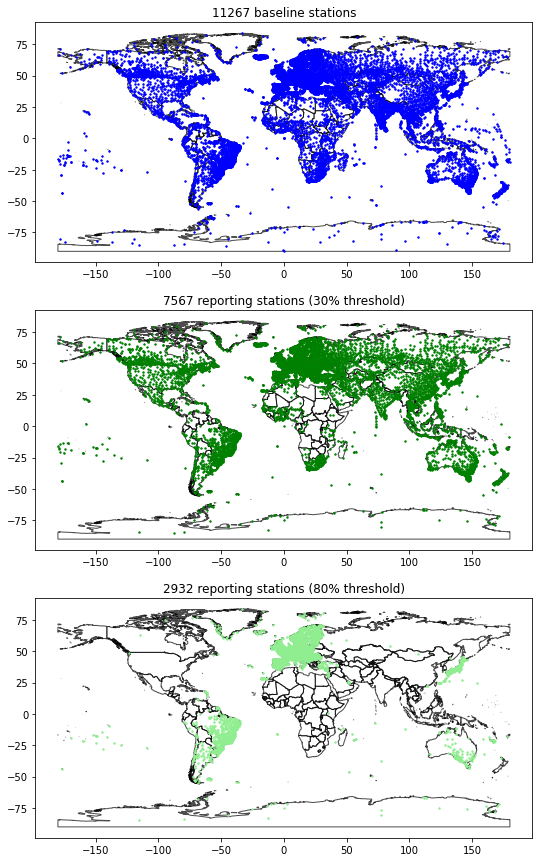

In [9]:
fig,(ax1,ax2,ax3) = plt.subplots(3,figsize=(15,15))

gdf_world.plot(ax=ax1,alpha=0.7,facecolor="none")
gdf_baseline.plot(ax=ax1,markersize=2,color="blue")
ax1.set_title("{} baseline stations".format(len(gdf_baseline)))

gdf_world.plot(ax=ax2,alpha=0.7,facecolor="none")
gdf_reporting.plot(ax=ax2,markersize=2,color="green")
ax2.set_title("{} reporting stations (30% threshold)".format(len(gdf_reporting)))

gdf_world.plot(ax=ax3,alpha=0.7,facecolor="none")
gdf_reporting_2.plot(ax=ax3,markersize=2,color="lightgreen")
ax3.set_title("{} reporting stations (80% threshold)".format(len(gdf_reporting_2)))


In [10]:
def station_to_country(stations,plot=False):

    stations = stations.reset_index()
    
    station_cols = ["wigosid","name","country_id","index_right","geometry"]
    tmp = gpd.sjoin(stations,gdf_world_area,op="within",how="left")[station_cols].rename(columns={"index_right":"ISO3_CODE"})
    idx_stations_in_country = ~tmp.ISO3_CODE.isna() & ~(tmp.ISO3_CODE=="ATA")
    stations_in_country = tmp[idx_stations_in_country].copy() # stations inside a country boundary

    stations_outside_country =  tmp[~idx_stations_in_country] 
    tmp = gpd.sjoin(stations_outside_country,gdf_eez,op="within",how="left")[ station_cols ].rename(columns={"index_right":"ISO3_CODE"}) 
    idx_stations_in_eez = ~tmp.ISO3_CODE.isna() & ~(tmp.ISO3_CODE=="ATA")
    stations_in_eez = tmp[idx_stations_in_eez].copy() # stations inside a country boundary

    stations_outside_eez = tmp[idx_stations_in_eez]

    # calculate distance to home country
    stations_outside_eez_with_country = stations_outside_eez[~stations_outside_eez.country_id.isna()]

    problem_stations = []
    stations_close_to_home = []
    stations_far_from_home = []
    for i,o in stations_outside_eez_with_country.iterrows():
        if not o.country_id in gdf_world_area.index: #discard stations 
            print("discarding",o.country_id)
            continue
        try:
            d=o.geometry.distance(gdf_world_area.loc[[o.country_id,]].geometry[0])
            if d <= 1.0:
                stations_close_to_home.append(o)
            else:
                stations_far_from_home.append(o)
        except TypeError:
            problem_stations.append(o)

    stations_close_to_home = gpd.GeoDataFrame(stations_close_to_home)
    stations_far_from_home = gpd.GeoDataFrame(stations_far_from_home)

    # calculate distance to home EEZ (we have excluded station without a home country_id already)
    stations_close_to_eez = []
    stations_far_from_eez = []
    for i,o in stations_far_from_home.iterrows():
        try:
            d  = min([ o.geometry.distance( g ) for g in gdf_eez.loc[o.country_id].geometry ])
            if d <= 1.0:
                stations_close_to_eez.append(o)
            else:
                stations_far_from_eez.append(o)
        except TypeError:
            problem_stations.append(o)
    stations_close_to_eez = gpd.GeoDataFrame(stations_close_to_eez)
    stations_far_from_eez = gpd.GeoDataFrame(stations_far_from_eez)

    # finally.. yellow stations outside the country borders and EEZ
    #TODO

    # consolidate COUNTRY ID
    idx_no_country = stations_in_country.country_id.isna()
    stations_in_country.loc[idx_no_country,"country_id"] = stations_in_country.loc[idx_no_country,"ISO3_CODE"]
    stations_in_country.drop(["ISO3_CODE",],axis=1,inplace=True)

    idx_no_country = stations_in_eez.country_id.isna()
    stations_in_eez.loc[idx_no_country,"country_id"] = stations_in_eez.loc[idx_no_country,"ISO3_CODE"]
    stations_in_eez.drop(["ISO3_CODE",],axis=1,inplace=True)

    idx_no_country = stations_close_to_home.country_id.isna()
    stations_close_to_home.loc[idx_no_country,"country_id"] = stations_close_to_home.loc[idx_no_country,"ISO3_CODE"]
    stations_close_to_home.drop(["ISO3_CODE",],axis=1,inplace=True)

    idx_no_country = stations_close_to_eez.country_id.isna()
    stations_close_to_eez.loc[idx_no_country,"country_id"] = stations_close_to_eez.loc[idx_no_country,"ISO3_CODE"]
    stations_close_to_eez.drop(["ISO3_CODE",],axis=1,inplace=True)

    gdf_baseline = gpd.GeoDataFrame( pd.concat( [stations_in_country,stations_in_eez,stations_close_to_home,stations_close_to_eez], ignore_index=True) )
    gdf_baseline.crs="epsg:4326"

    if plot:
        print("nr close home",len(stations_close_to_home))
        print("nr close EEZ",len(stations_close_to_eez))
        print("nr far EEZ",len(stations_far_from_eez))

        ax=gdf_world_area.plot(figsize=(20,20))
        stations_in_country.plot(ax=ax,color="green",markersize=2)
        stations_in_eez.plot(ax=ax,color="lightgreen",markersize=2)
        stations_close_to_home.plot(ax=ax,color="orange",markersize=2)

        stations_close_to_eez.plot(ax=ax,color="cyan",markersize=2)
        stations_far_from_eez.plot(ax=ax,color="red",markersize=18)
        
    return gdf_baseline


baseline_stations = station_to_country(gdf_baseline)
reporting_stations_30 = station_to_country(gdf_reporting)
#reporting_stations_80 = station_to_country(gdf_reporting_2)

discarding CW
discarding CW


In [11]:
def calculate_HR(stations,colsuffix=None):
    
    colname="HR_" + colsuffix
    colname_stations = "nr_stations_" + colsuffix

    stations_by_country = stations.groupby("country_id").wigosid.count().to_frame()
    stations_by_country = stations_by_country.rename(columns={"wigosid":colname_stations})
    
    country_hr = stations_by_country.join(gdf_world_area,how="right")
    
    country_hr[colname] = np.sqrt(country_hr.surface_area_total_km2) / np.sqrt(country_hr[colname_stations])
    
    return country_hr[[colname,colname_stations]]
        
hr_baseline = calculate_HR(baseline_stations,"baseline")
hr_reporting_30 = calculate_HR(reporting_stations_30,"reporting_30")
#hr_reporting_80 = calculate_HR(reporting_stations_80,"reporting_80")


df_analysis = pd.concat([hr_baseline,hr_reporting_30],axis=1)
df_analysis.head()

,HR_baseline,nr_stations_baseline,HR_reporting_30,nr_stations_reporting_30
AFG,233.248794,12.0,NaN,NaN
AGO,303.123911,19.0,NaN,NaN
AIA,NaN,NaN,NaN,NaN
ALB,60.485911,11.0,63.438159,10.0
AND,NaN,NaN,NaN,NaN


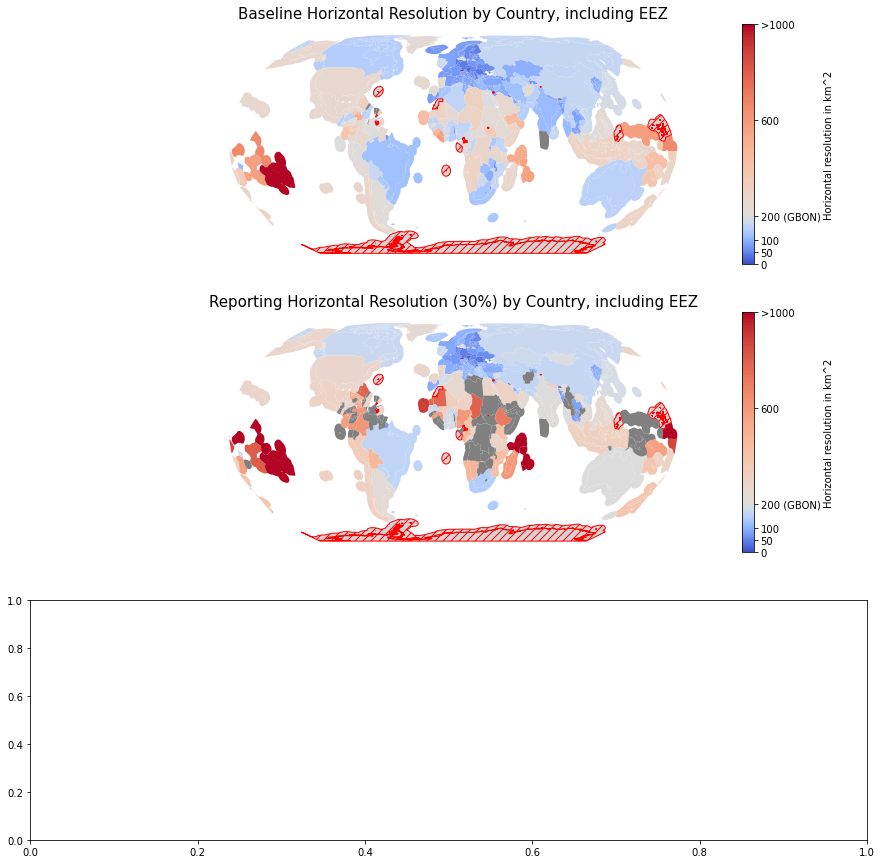

In [12]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(15,15))

def plot_HR(df,column,title,ax):
    """Plots the HR indicated in `column` into the map passed in `df`.
    The EEZ of the country are also plotted in the same color.
    Non-WMO Member states are plotted in grey with red borders.
    WMO Members with zero HR are shown black
    """
    
    # join data to member info
    df = gdf_world_area.join(df[column],how="left")
    
    # select members to print
    idx_member = df.STATUS == "WMO Member"
    wmo_members = df[idx_member].index.values    
    
    idx_missing = ( df[column].isna() & idx_member ) 
    
    # plot config
    missing = {   "color": "lightgrey", "edgecolor": "red",
                   "hatch": "///", "label": "Missing values" }

    #min_hr = df[column].min()
    #max_hr = df[column].max()
    
    cmap="coolwarm"
    norm = colors.TwoSlopeNorm(vmin=0, vcenter=200., vmax=1000)    
    cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

    # plot countries
    df[idx_member].to_crs("+proj=eqearth").plot(column=column, legend=False, cmap=cmap, norm=norm, ax=ax )
    df[~df.index.isin(wmo_members)].to_crs("+proj=eqearth").plot(ax=ax, **missing) #plot non Members
    df[idx_missing].to_crs("+proj=eqearth").plot(facecolor="grey",ax=ax)

    # add HR info to EEZ geodataframe
    df_eez = gdf_eez.join(df[column],how='inner') 
    idx_member = df_eez.index.isin(wmo_members)
    idx_missing = ( df_eez[column].isna() & idx_member )
    
    # plot EEZ
    df_eez[idx_member].to_crs("+proj=eqearth").plot(column=column, legend=False, cmap=cmap, norm=norm, ax=ax)
    df_eez[~idx_member].to_crs("+proj=eqearth").plot(ax=ax,**missing) #plot non Members EEZ
    df_eez[idx_missing].to_crs("+proj=eqearth").plot(facecolor="grey",ax=ax)

    # configure plot
    ax.set_title(title, fontsize=15)
    ticks=[0,50,100,200,600,1000]
    ax_cbar = fig.colorbar( cbar , ax=ax, ticks=ticks)
    ax_cbar.set_label('Horizontal resolution in km^2')
    ax_cbar.ax.set_yticklabels(["0","50","100","200 (GBON)","600",">1000"])
    
    ax.axis("off")
    
plot_HR(df_analysis,"HR_baseline","Baseline Horizontal Resolution by Country, including EEZ",ax1)
plot_HR(df_analysis,"HR_reporting_30","Reporting Horizontal Resolution (30%) by Country, including EEZ",ax2)
#plot_HR(df_analysis,"HR_reporting_80","Reporting Horizontal Resolution (80%) by Country, including EEZ",ax3)
    
    
#plt.savefig(r'C:\TEMP\GBON-res.png')

# Density estimation with KDE 
Make a kernel density estimation of each country using a tophat kernel and haversine distance.
We compute a grid of the world first and determine the country of each of the gridpoints.
It can be used to only compute the denstiy for points inside a country

In [13]:
import json
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KernelDensity
from mpl_toolkits.basemap import Basemap

In [14]:
def construct_global_grid(world,eez,width=0.05):
    x_min = -180
    x_max = 180
    
    y_min = -90
    y_max = 90
       
    x_steps = (x_max-x_min) / width
    y_steps = (y_max-y_min) / width
    
    xgrid = np.linspace(x_min,x_max,x_steps)
    ygrid = np.linspace(y_min,y_max,y_steps)
    
    X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
    xy = np.vstack([Y.ravel(), X.ravel()]).T
   
    gdf_grid = gpd.GeoDataFrame( geometry=gpd.points_from_xy( xy[:,1],xy[:,0] ) , crs="epsg:4326" )
   
    gdf_grid = gpd.sjoin(gdf_grid,world.reset_index(),op="within",how="left").drop(["index_right",],axis=1)
    gdf_grid = gdf_grid[~gdf_grid.index.duplicated(keep="first")] 

    tmp=gpd.sjoin(gdf_grid[gdf_grid.POL_C_CODE.isna()].drop(["POL_C_CODE",],axis=1) , eez.reset_index() ,op="within",how="left")
    tmp=tmp[~tmp.index.duplicated(keep="first")]

    gdf_grid.loc[tmp.index,"POL_C_CODE"] = tmp["index"]
    
    return xy,gdf_grid[["POL_C_CODE",]],X,Y

xy,gdf_grid,X,Y=construct_global_grid(gdf_world_area,gdf_eez)


In [15]:
def compute_density(stations,grid,xy,X,Y,iso3,plot=True):
    
    stations=stations[stations.country_id==iso3]
    #print("len stations: {}, len grid: {} len xy: {}".format(len(stations),len(grid),len(xy)))

    country_mask = grid.POL_C_CODE==iso3
    
    if len(stations)==0 :
        ret = np.zeros(1)
        print("zero stations in",iso3)
        return ret , ret==0
    if country_mask.sum()==0:
        ret = np.zeros(1)
        print("no country mask for",iso3)
        return ret , ret==0

    latlong=np.vstack([stations.geometry.y,stations.geometry.x]).T
    
    xy = np.radians(xy[country_mask] ) # apply land mask
    
    # distance as measured by haversine. Multiply by 6371000/1000 to get distaince in km
    HR = 200
    bandwidth = (HR)  / 6371 #  6371 being the radius of the earth

    cmap = 'Reds'

    if plot:
        fig,ax=plt.subplots(2,1,figsize=(20,8))
        # plot coastlines with basemap
        ax[0].set_title( "{} density with tophat kernel and HR {} km".format(iso3,HR))
        m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                    urcrnrlat=Y.max(), llcrnrlon=X.min(),
                    urcrnrlon=X.max(), resolution='c', ax=ax[0])
        m.drawmapboundary(fill_color='#DDEEFF')
        m.drawcoastlines()
        m.drawcountries()

    # construct a spherical kernel density estimate of the distribution
    kde = KernelDensity(bandwidth=bandwidth, kernel="tophat" , metric='haversine')
    kde.fit(np.radians(latlong))
    #Z = kde.score_samples(xy)
    #Z = np.exp(kde.score_samples(xy))
    
    # evaluate only on the land: -9999 indicates ocean
    Z = np.full(country_mask.shape[0], -1)
    Z[country_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)

    if plot:
        # plot contours of the density
        levels = np.linspace(0.01,Z.max(),10)

        cs3 = ax[0].contourf(X, Y, Z, levels=levels, cmap=cmap)
        #cs3 = ax[0].contourf(X, Y, Z,  cmap=cmap)

        fig.colorbar(cs3,ax=ax[0])

        # plot points for comparison
        m = Basemap(projection='cyl', resolution='c',
                    llcrnrlat=Y.min(), urcrnrlat=Y.max(),
                    llcrnrlon=X.min(), urcrnrlon=X.max(),ax=ax[1])
        m.drawmapboundary(fill_color='#DDEEFF')
        m.fillcontinents(color='#FFEEDD')
        m.drawcoastlines(color='gray', zorder=2)
        m.drawcountries(color='gray', zorder=2)

        # plot locations
        m.scatter(latlong[:, 1], latlong[:, 0], zorder=3, s=2,
                   cmap='rainbow', latlon=True);

        ax[1].set_title(iso3+" stations")
        
    return Z,country_mask 
    
#density,mask = compute_density(gdf_baseline,gdf_grid,xy,X,Y,"AUS",plot=True)
        

In [16]:
def compute_HR_KDE(stations): 
    res = {}
    for country_id in gdf_world_area.index.values:
        
        density,mask = compute_density(gdf_baseline,gdf_grid,xy,X,Y,country_id,plot=False)
        
        density = density.ravel()
        density = density[mask]

        std_nrml_den = 0 if density.sum()==0 else  (density / density.max()).std()
        std_den = density.std()
        mean_den = density.mean()
        
        res[country_id] = {"mean":mean_den,"std":std_den, "std_normalized":std_nrml_den}
        #print(res[country_id])
        
    return pd.DataFrame.from_dict(res,orient="index")

kde_hr_baseline = compute_HR_KDE(baseline_stations)
kde_hr_reporting_30 = compute_HR_KDE(reporting_stations_30)
#kde_hr_reporting_80 = compute_HR_KDE(reporting_stations_80)

zero stations in MSR
zero stations in TCA
zero stations in AND
zero stations in ATA
zero stations in BMU
zero stations in BTN
zero stations in CUW
zero stations in LIE
no country mask for MAC
zero stations in MCO
zero stations in SMR
zero stations in VAT
zero stations in VCT
zero stations in XX1
zero stations in PSE
zero stations in XX3
zero stations in ESH
zero stations in VGB
zero stations in MSR
zero stations in TCA
zero stations in AND
zero stations in ATA
zero stations in BMU
zero stations in BTN
zero stations in CUW
zero stations in LIE
no country mask for MAC
zero stations in MCO
zero stations in SMR
zero stations in VAT
zero stations in VCT
zero stations in XX1
zero stations in PSE
zero stations in XX3
zero stations in ESH
zero stations in VGB


In [18]:
tmp=pd.concat([kde_hr_baseline,kde_hr_reporting_30],axis=1)

newcols = [ "HR_KDE_{}_{}".format(c,b) for c in ["baseline","reporting_30"] for b in ["mean","std","std_normalized"] ]
tmp.columns = newcols

df_analysis=df_analysis.join(tmp)

In [19]:
df_analysis.head()

,HR_baseline,nr_stations_baseline,HR_reporting_30,nr_stations_reporting_30,HR_KDE_baseline_mean,HR_KDE_baseline_std,HR_KDE_baseline_std_normalized,HR_KDE_reporting_30_mean,HR_KDE_reporting_30_std,HR_KDE_reporting_30_std_normalized
AFG,233.248794,12.0,NaN,NaN,53.952000,42.018754,0.260986,53.952000,42.018754,0.260986
AGO,303.123911,19.0,NaN,NaN,19.947346,19.465423,0.218713,19.947346,19.465423,0.218713
AIA,NaN,NaN,NaN,NaN,135.865079,159.452503,0.493661,135.865079,159.452503,0.493661
ALB,60.485911,11.0,63.438159,10.0,300.970588,31.686409,0.098100,300.970588,31.686409,0.098100
AND,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# nearest neighbours 

In [20]:
from sklearn.neighbors import BallTree

def get_nearest(src_points, candidates, k_neighbors=1, n_nearest=0):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=15, metric='haversine')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[n_nearest]
    closest_dist = distances[n_nearest]

    # Return indices and distances
    return (closest, closest_dist)

def nearest_neighbor(left_gdf, right_gdf, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.

    NOTICE: Assumes that the input Points are in WGS84 projection (lat/lon).
    """

    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.geometry.name

    # Ensure that index in right gdf is formed of sequential numbers
    right = right_gdf.copy().reset_index(drop=True)

    # Parse coordinates from points and insert them into a numpy array as RADIANS
    left_radians = np.array(left_gdf[left_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    right_radians = np.array(right[right_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())

    # Find the nearest points
    # -----------------------
    # closest ==> index in right_gdf that corresponds to the closest point
    # dist ==> distance between the nearest neighbors (in meters)

    closest, dist = get_nearest(src_points=left_radians, candidates=right_radians, k_neighbors=2, n_nearest=1)

    # Return points from right GeoDataFrame that are closest to points in left GeoDataFrame
    closest_points = right.loc[closest]

    # Ensure that the index corresponds the one in left_gdf
    closest_points = closest_points.reset_index(drop=True)

    # Add distance if requested
    if return_dist:
        # Convert to meters from radians
        earth_radius = 6371000  # meters
        closest_points['distance'] = dist * earth_radius

    return closest_points

#gdf_german_stations = gdf_baseline[gdf_baseline.country_id=="DEU"].reset_index().drop("index",axis=1)
#closest_german_stations = nearest_neighbor( gdf_german_stations, gdf_german_stations, return_dist=True)
#closest_german_stations
#closest_german_stations.join(gdf_german_stations,rsuffix="_right").head()

In [22]:
def calculate_HR_NN(stations):

    res = {}
    
    for country_id in gdf_world_area.index.values:
    
        tmp_stations = stations[stations.country_id==country_id].reset_index().drop("index",axis=1)
        if len(tmp_stations) > 1:
            closest_stations = nearest_neighbor( tmp_stations, tmp_stations, return_dist=True)

            mean = closest_stations["distance"].mean()
            std = closest_stations["distance"].std()
        else:
            mean,std = np.nan , np.nan
    
        res[country_id] =  {"mean" : mean , "std" : std }
        
    return pd.DataFrame.from_dict(res,orient="index")

nn_hr_baseline = calculate_HR_NN(baseline_stations)
nn_hr_reporting_30 = calculate_HR_NN(reporting_stations_30)
#nn_hr_reporting_80 = calculate_HR_NN(reporting_stations_80)

tmp=pd.concat([nn_hr_baseline,nn_hr_reporting_30],axis=1)

newcols = [ "HR_NN_{}_{}".format(c,b) for c in ["baseline","reporting_30"] for b in ["mean","std"] ]
tmp.columns = newcols

df_analysis=df_analysis.join(tmp)

In [29]:
output=df_analysis.join(gdf_world_area[["surface_area_km2_wb","eez_area_km2","int_water_km2","surface_area_total_km2","TERR_NAME","STATUS"]])

In [31]:
output.to_csv("GBON-HZ.csv",encoding="utf8")